In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

In [3]:
train_path = '/kaggle/input/adobetraindata/behaviour_simulation_train.csv'
test_path = '/kaggle/input/inter-iit-mid-prep-adobe/problem_1_test_dataset/behaviour_simulation_test_company.xlsx'

In [4]:
test_dataset = pd.read_excel(test_path)

In [5]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                10000 non-null  int64 
 1   date              10000 non-null  object
 2   content           10000 non-null  object
 3   username          10000 non-null  object
 4   media             10000 non-null  object
 5   inferred company  10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [6]:
train_dataset = pd.read_csv(train_path)

In [7]:
train_dataset

,id,date,likes,content,username,media,inferred company
0,1,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[Photo(previewUrl='https://pbs.twimg.com/media...,tim hortons
1,2,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
2,3,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[Photo(previewUrl='https://pbs.twimg.com/media...,cbc
3,4,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
4,5,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
...,...,...,...,...,...,...,...
299995,299996,2019-09-07 16:18:10,0,Barcelona Star Expected To Return Against Vale...,IndependentNGR,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
299996,299997,2018-02-23 11:24:36,46,Kjeld Nuis of #NED is golden again... This tim...,CBCOlympics,[Video(thumbnailUrl='https://pbs.twimg.com/med...,cbc
299997,299998,2020-11-11 20:18:15,261,Grateful 🙌🏾 to have <mention> officially join ...,TeamCoachBuzz,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
299998,299999,2019-10-29 10:44:00,119,The US Air Force's mysterious space plane just...,Independent,[Video(thumbnailUrl='https://pbs.twimg.com/med...,independent


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
# Load data
train_data = train_dataset.copy()
test_data = test_dataset.copy()
# Bin the likes into categories
# Define the cap threshold
cap_value = 20000
# Apply the cap to the 'likes' column
train_data['likes_capped'] = train_data['likes'].apply(lambda x: min(x, cap_value))
# Check the distribution of the capped 'likes' column
print(train_data['likes_capped'].describe())
bins = [0, 100, 1000, 10000, 100000]
labels = ['0-100', '101-1k','1k-10k','10k+']
train_data['likes_binned'] = pd.cut(train_data['likes_capped'], bins=bins, labels=labels, include_lowest=True)
# Sample 10% of the data, stratified by binned likes
sample_fraction = 0.01  # Change this to 1.0 for 100%
train_data_sampled, _ = train_test_split(train_data, test_size=1-sample_fraction, random_state=42, stratify=train_data['likes_binned'])
train_data_sampled = train_data_sampled.reset_index(drop=1)
train_data_sampled = train_data.copy()

# Check distribution
print(train_data_sampled['likes_binned'].value_counts(normalize=True))


count    300000.000000
mean        643.547447
std        2128.732465
min           0.000000
25%           3.000000
50%          76.000000
75%         364.000000
max       20000.000000
Name: likes_capped, dtype: float64
likes_binned
0-100     0.548557
101-1k    0.327200
1k-10k    0.111780
10k+      0.012463
Name: proportion, dtype: float64


In [9]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [10]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import networkx as nx
from node2vec import Node2Vec
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import emoji

# Ensure you've downloaded necessary NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# def preprocess_text(text):
#     # Convert to lowercase
#     text = text.lower()
#     # Remove URLs
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
#     # Remove user mentions
#     text = re.sub(r'@\w+', '', text)
#     # Remove non-letter characters
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     # Remove extra spaces
#     text = re.sub(r'\s+', ' ', text).strip()
#     # Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     text = ' '.join([word for word in text.split() if word not in stop_words])
#     return text

# def get_roberta_embedding(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).numpy().flatten()

# def get_datetime_features(date_str):
#     date = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
#     return np.array([
#         date.year, date.month, date.day, date.hour, date.minute,
#         date.weekday(), date.timetuple().tm_yday,
#         np.sin(2 * np.pi * date.hour / 24),  # Cyclical encoding for hour
#         np.cos(2 * np.pi * date.hour / 24),
#         np.sin(2 * np.pi * date.month / 12),  # Cyclical encoding for month
#         np.cos(2 * np.pi * date.month / 12)
#     ])

# def get_categorical_embedding(value, encoder):
#     return encoder.transform([[value]]).toarray().flatten()

# def create_graph_embedding(df):
#     G = nx.Graph()
#     for _, row in df.iterrows():
#         G.add_edge(row['username'], row['inferred company'])
#         for mention in re.findall(r'@(\w+)', row['content']):
#             G.add_edge(row['username'], mention)
    
#     node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
#     model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
#     def get_node_embedding(node):
#         try:
#             return model.wv[node]
#         except KeyError:
#             return np.zeros(64)
    
#     df['user_graph_embedding'] = df['username'].apply(get_node_embedding)
#     df['company_graph_embedding'] = df['inferred company'].apply(get_node_embedding)
#     return df

# def extract_hashtags(text):
#     return ' '.join(re.findall(r'#(\w+)', text))

# def extract_emoji(text):
#     return ' '.join([c for c in text if c in emoji.UNICODE_EMOJI['en']])

# # Load the data
# df = pd.read_csv("tweets.csv")

# # Preprocess text
# df['processed_content'] = df['content'].apply(preprocess_text)
# df['hashtags'] = df['content'].apply(extract_hashtags)
# df['emojis'] = df['content'].apply(extract_emoji)

# # Combine all text data
# df['combined_text'] = df.apply(lambda row: f"{row['processed_content']} {row['username']} {row['inferred company']} {row['hashtags']} {row['emojis']}", axis=1)

# # Generate text embeddings
# df['combined_embedding'] = df['combined_text'].apply(get_roberta_embedding)

# # Generate datetime embeddings
# df['datetime_embedding'] = df['date'].apply(get_datetime_features)

# # Generate categorical embeddings
# company_encoder = OneHotEncoder(sparse=False)
# company_encoder.fit(df['inferred company'].values.reshape(-1, 1))
# df['company_embedding'] = df['inferred company'].apply(lambda x: get_categorical_embedding(x, company_encoder))

# # Generate graph embeddings
# df = create_graph_embedding(df)

# # Combine all embeddings
# df['rich_embedding'] = df.apply(lambda row: np.concatenate([
#     row['combined_embedding'],
#     row['datetime_embedding'],
#     row['company_embedding'],
#     row['user_graph_embedding'],
#     row['company_graph_embedding']
# ]), axis=1)

# print("Rich embeddings generated successfully!")
# print(f"Shape of rich embedding: {df['rich_embedding'].iloc[0].shape}")

# # Optional: Dimensionality reduction if needed
# # from sklearn.decomposition import PCA
# # pca = PCA(n_components=100)
# # df['reduced_embedding'] = list(pca.fit_transform(np.stack(df['rich_embedding'])))

# # Save the embeddings
# np.save('rich_tweet_embeddings.npy', np.stack(df['rich_embedding']))
# df[['id', 'content', 'username', 'inferred company']].to_csv('tweet_metadata.csv', index=False)

# print("Embeddings and metadata saved successfully!")

In [12]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime
import networkx as nx
from node2vec import Node2Vec
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import emoji
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load specialized Twitter model
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Using device: cuda


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [13]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove non-letter characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def get_roberta_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

def get_datetime_features(date_str):
    date = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    return np.array([
        date.year, date.month, date.day, date.hour, date.minute,
        date.weekday(), date.timetuple().tm_yday,
        np.sin(2 * np.pi * date.hour / 24),  # Cyclical encoding for hour
        np.cos(2 * np.pi * date.hour / 24),
        np.sin(2 * np.pi * date.month / 12),  # Cyclical encoding for month
        np.cos(2 * np.pi * date.month / 12)
    ])

def get_categorical_embedding(value, encoder):
    return encoder.transform([[value]]).flatten()

def create_graph_embedding(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['username'], row['inferred company'])
        for mention in re.findall(r'@(\w+)', row['content']):
            G.add_edge(row['username'], mention)
    
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    def get_node_embedding(node):
        try:
            return model.wv[node]
        except KeyError:
            return np.zeros(64)
    
    df['user_graph_embedding'] = df['username'].apply(get_node_embedding)
    df['company_graph_embedding'] = df['inferred company'].apply(get_node_embedding)
    return df

def extract_hashtags(text):
    return ' '.join(re.findall(r'#(\w+)', text))

def extract_emoji(text):
    return ' '.join([c for c in text if emoji.is_emoji(c)])

In [14]:
# Load the data
df = train_data_sampled.copy()

# Preprocess text and combine data
print("Preprocessing text...")
df['processed_content'] = df['content'].apply(preprocess_text)
df['hashtags'] = df['content'].apply(extract_hashtags)
df['emojis'] = df['content'].apply(extract_emoji)
df['combined_text'] = df.apply(lambda row: f"{row['processed_content']} {row['username']} {row['inferred company']} {row['hashtags']} {row['emojis']}", axis=1)

Preprocessing text...


In [15]:
# Generate embeddings with progress bar
print("Generating embeddings...")
embeddings = []
for text in tqdm(df['combined_text'], desc="Generating text embeddings"):
    embeddings.append(get_roberta_embedding(text))
df['combined_embedding'] = embeddings

Generating embeddings...


Generating text embeddings: 100%|██████████| 300000/300000 [42:36<00:00, 117.34it/s]


In [16]:
# Generate other embeddings
print("Generating other embeddings...")
df['datetime_embedding'] = df['date'].apply(get_datetime_features)

company_encoder = OneHotEncoder(sparse=False)
company_encoder.fit(df['inferred company'].values.reshape(-1, 1))
df['company_embedding'] = df['inferred company'].apply(lambda x: get_categorical_embedding(x, company_encoder))

Generating other embeddings...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
# print("Creating graph embeddings...")
# df = create_graph_embedding(df)

In [18]:
# Combine all embeddings
print("Combining embeddings...")
df['rich_embedding'] = df.apply(lambda row: np.concatenate([
    row['combined_embedding'],
    row['datetime_embedding'],
    row['company_embedding']
    # row['user_graph_embedding'],
    # row['company_graph_embedding']
]), axis=1)

print(f"Shape of rich embedding: {df['rich_embedding'].iloc[0].shape}")

Combining embeddings...
Shape of rich embedding: (999,)


In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Prepare data for regression
X = np.stack(df['rich_embedding'])
y = df['likes_capped'].values

# Log transform the target variable to handle skewness
y = np.log1p(y)  # log1p is used to handle zero values

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [21]:
# Define a neural network for regression
class TweetLikesRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(TweetLikesRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x.squeeze()

# Create dataset and dataloader
class TweetDataset(Dataset):
    def __init__(self, embeddings, likes):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.likes = torch.tensor(likes, dtype=torch.float32)
    
    def __len__(self):
        return len(self.likes)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.likes[idx]

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
batch_size = 64
num_epochs = 100
learning_rate = 0.001

In [22]:
# Create model, optimizer, and loss function
model = TweetLikesRegressor(input_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [23]:
# Create datasets and dataloaders
train_dataset = TweetDataset(X_train_scaled, y_train)
val_dataset = TweetDataset(X_val_scaled, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [24]:
# Training loop
print("Training regression model...")
best_val_mse = float('inf')
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_embeddings, batch_likes in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_embeddings, batch_likes = batch_embeddings.to(device), batch_likes.to(device)
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_likes)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch_embeddings, batch_likes in val_loader:
            batch_embeddings, batch_likes = batch_embeddings.to(device), batch_likes.to(device)
            outputs = model(batch_embeddings)
            val_preds.extend(outputs.cpu().numpy())
            val_true.extend(batch_likes.cpu().numpy())
    
    val_mse = mean_squared_error(val_true, val_preds)
    val_mae = mean_absolute_error(val_true, val_preds)
    val_r2 = r2_score(val_true, val_preds)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")
    print(f"Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}, Val R2: {val_r2:.4f}")
    
    # Save the best model
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        torch.save(model.state_dict(), 'best_tweet_likes_regressor.pth')
        print("New best model saved!")

print("Training completed!")

Training regression model...


Epoch 1/100: 100%|██████████| 3750/3750 [00:08<00:00, 424.30it/s]


Epoch 1/100, Loss: 1.4185
Val MSE: 0.9779, Val MAE: 0.7045, Val R2: 0.8556
New best model saved!


Epoch 2/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.79it/s]


Epoch 2/100, Loss: 1.1305
Val MSE: 0.8958, Val MAE: 0.6667, Val R2: 0.8677
New best model saved!


Epoch 3/100: 100%|██████████| 3750/3750 [00:08<00:00, 441.08it/s]


Epoch 3/100, Loss: 1.0567
Val MSE: 0.8472, Val MAE: 0.6691, Val R2: 0.8749
New best model saved!


Epoch 4/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.73it/s]


Epoch 4/100, Loss: 1.0444
Val MSE: 0.8481, Val MAE: 0.6692, Val R2: 0.8748


Epoch 5/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.88it/s]


Epoch 5/100, Loss: 1.0547
Val MSE: 0.8261, Val MAE: 0.6385, Val R2: 0.8780
New best model saved!


Epoch 6/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.00it/s]


Epoch 6/100, Loss: 0.9889
Val MSE: 0.9054, Val MAE: 0.6611, Val R2: 0.8663


Epoch 7/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.53it/s]


Epoch 7/100, Loss: 0.9420
Val MSE: 0.7809, Val MAE: 0.6411, Val R2: 0.8847
New best model saved!


Epoch 8/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.31it/s]


Epoch 8/100, Loss: 0.9069
Val MSE: 0.7901, Val MAE: 0.6525, Val R2: 0.8833


Epoch 9/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.90it/s]


Epoch 9/100, Loss: 0.9074
Val MSE: 0.9029, Val MAE: 0.6450, Val R2: 0.8667


Epoch 10/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.59it/s]


Epoch 10/100, Loss: 1.0283
Val MSE: 0.7877, Val MAE: 0.6356, Val R2: 0.8837


Epoch 11/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.76it/s]


Epoch 11/100, Loss: 0.9359
Val MSE: 0.7657, Val MAE: 0.6252, Val R2: 0.8869
New best model saved!


Epoch 12/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.05it/s]


Epoch 12/100, Loss: 0.8993
Val MSE: 0.8198, Val MAE: 0.6670, Val R2: 0.8790


Epoch 13/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.99it/s]


Epoch 13/100, Loss: 0.8930
Val MSE: 0.7704, Val MAE: 0.6419, Val R2: 0.8863


Epoch 14/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.56it/s]


Epoch 14/100, Loss: 0.8829
Val MSE: 0.8055, Val MAE: 0.6569, Val R2: 0.8811


Epoch 15/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.80it/s]


Epoch 15/100, Loss: 0.8608
Val MSE: 0.7687, Val MAE: 0.6393, Val R2: 0.8865


Epoch 16/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.42it/s]


Epoch 16/100, Loss: 0.8579
Val MSE: 0.8260, Val MAE: 0.6743, Val R2: 0.8780


Epoch 17/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.47it/s]


Epoch 17/100, Loss: 0.8301
Val MSE: 0.7457, Val MAE: 0.6131, Val R2: 0.8899
New best model saved!


Epoch 18/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.81it/s]


Epoch 18/100, Loss: 0.8092
Val MSE: 0.7342, Val MAE: 0.6091, Val R2: 0.8916
New best model saved!


Epoch 19/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.01it/s]


Epoch 19/100, Loss: 0.8180
Val MSE: 0.7418, Val MAE: 0.6124, Val R2: 0.8905


Epoch 20/100: 100%|██████████| 3750/3750 [00:08<00:00, 443.39it/s]


Epoch 20/100, Loss: 0.8035
Val MSE: 0.7301, Val MAE: 0.6047, Val R2: 0.8922
New best model saved!


Epoch 21/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.54it/s]


Epoch 21/100, Loss: 0.8142
Val MSE: 0.7817, Val MAE: 0.6353, Val R2: 0.8846


Epoch 22/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.99it/s]


Epoch 22/100, Loss: 0.7864
Val MSE: 0.7471, Val MAE: 0.6223, Val R2: 0.8897


Epoch 23/100: 100%|██████████| 3750/3750 [00:08<00:00, 443.14it/s]


Epoch 23/100, Loss: 0.7701
Val MSE: 0.7824, Val MAE: 0.6609, Val R2: 0.8845


Epoch 24/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.17it/s]


Epoch 24/100, Loss: 0.7675
Val MSE: 0.7467, Val MAE: 0.6183, Val R2: 0.8898


Epoch 25/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.36it/s]


Epoch 25/100, Loss: 0.7534
Val MSE: 0.7299, Val MAE: 0.6177, Val R2: 0.8922
New best model saved!


Epoch 26/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.86it/s]


Epoch 26/100, Loss: 0.7792
Val MSE: 0.7226, Val MAE: 0.6015, Val R2: 0.8933
New best model saved!


Epoch 27/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.98it/s]


Epoch 27/100, Loss: 0.7519
Val MSE: 0.7333, Val MAE: 0.6146, Val R2: 0.8917


Epoch 28/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.18it/s]


Epoch 28/100, Loss: 0.7385
Val MSE: 0.7331, Val MAE: 0.6198, Val R2: 0.8918


Epoch 29/100: 100%|██████████| 3750/3750 [00:08<00:00, 442.12it/s]


Epoch 29/100, Loss: 0.7262
Val MSE: 0.7202, Val MAE: 0.6102, Val R2: 0.8937
New best model saved!


Epoch 30/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.76it/s]


Epoch 30/100, Loss: 0.7184
Val MSE: 0.7361, Val MAE: 0.6000, Val R2: 0.8913


Epoch 31/100: 100%|██████████| 3750/3750 [00:08<00:00, 426.66it/s]


Epoch 31/100, Loss: 0.7106
Val MSE: 0.7392, Val MAE: 0.6009, Val R2: 0.8909


Epoch 32/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.50it/s]


Epoch 32/100, Loss: 0.7070
Val MSE: 0.7302, Val MAE: 0.6252, Val R2: 0.8922


Epoch 33/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.04it/s]


Epoch 33/100, Loss: 0.7000
Val MSE: 0.7089, Val MAE: 0.5980, Val R2: 0.8953
New best model saved!


Epoch 34/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.96it/s]


Epoch 34/100, Loss: 0.6883
Val MSE: 0.7133, Val MAE: 0.5988, Val R2: 0.8947


Epoch 35/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.64it/s]


Epoch 35/100, Loss: 0.6858
Val MSE: 0.7564, Val MAE: 0.6387, Val R2: 0.8883


Epoch 36/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.34it/s]


Epoch 36/100, Loss: 0.6907
Val MSE: 0.7588, Val MAE: 0.6286, Val R2: 0.8880


Epoch 37/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.98it/s]


Epoch 37/100, Loss: 0.7099
Val MSE: 0.7656, Val MAE: 0.6520, Val R2: 0.8870


Epoch 38/100: 100%|██████████| 3750/3750 [00:08<00:00, 428.01it/s]


Epoch 38/100, Loss: 0.6780
Val MSE: 0.7383, Val MAE: 0.6265, Val R2: 0.8910


Epoch 39/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.76it/s]


Epoch 39/100, Loss: 0.6796
Val MSE: 0.7217, Val MAE: 0.6060, Val R2: 0.8934


Epoch 40/100: 100%|██████████| 3750/3750 [00:08<00:00, 441.21it/s]


Epoch 40/100, Loss: 0.6673
Val MSE: 0.7356, Val MAE: 0.6229, Val R2: 0.8914


Epoch 41/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.81it/s]


Epoch 41/100, Loss: 0.6611
Val MSE: 0.7407, Val MAE: 0.6308, Val R2: 0.8906


Epoch 42/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.79it/s]


Epoch 42/100, Loss: 0.6571
Val MSE: 0.7500, Val MAE: 0.6396, Val R2: 0.8893


Epoch 43/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.45it/s]


Epoch 43/100, Loss: 0.7393
Val MSE: 0.7488, Val MAE: 0.6283, Val R2: 0.8894


Epoch 44/100: 100%|██████████| 3750/3750 [00:08<00:00, 426.52it/s]


Epoch 44/100, Loss: 0.6934
Val MSE: 0.7767, Val MAE: 0.6447, Val R2: 0.8853


Epoch 45/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.31it/s]


Epoch 45/100, Loss: 0.6862
Val MSE: 0.7729, Val MAE: 0.6461, Val R2: 0.8859


Epoch 46/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.17it/s]


Epoch 46/100, Loss: 0.6681
Val MSE: 0.7586, Val MAE: 0.6483, Val R2: 0.8880


Epoch 47/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.49it/s]


Epoch 47/100, Loss: 0.7051
Val MSE: 0.7564, Val MAE: 0.6405, Val R2: 0.8883


Epoch 48/100: 100%|██████████| 3750/3750 [00:08<00:00, 424.79it/s]


Epoch 48/100, Loss: 0.6722
Val MSE: 0.7545, Val MAE: 0.6395, Val R2: 0.8886


Epoch 49/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.37it/s]


Epoch 49/100, Loss: 0.6464
Val MSE: 0.7354, Val MAE: 0.6151, Val R2: 0.8914


Epoch 50/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.63it/s]


Epoch 50/100, Loss: 0.6339
Val MSE: 0.7377, Val MAE: 0.6192, Val R2: 0.8911


Epoch 51/100: 100%|██████████| 3750/3750 [00:08<00:00, 424.52it/s]


Epoch 51/100, Loss: 0.6349
Val MSE: 0.7289, Val MAE: 0.6148, Val R2: 0.8924


Epoch 52/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.70it/s]


Epoch 52/100, Loss: 0.6202
Val MSE: 0.7167, Val MAE: 0.6063, Val R2: 0.8942


Epoch 53/100: 100%|██████████| 3750/3750 [00:08<00:00, 442.24it/s]


Epoch 53/100, Loss: 0.6146
Val MSE: 0.7236, Val MAE: 0.6081, Val R2: 0.8932


Epoch 54/100: 100%|██████████| 3750/3750 [00:08<00:00, 428.56it/s]


Epoch 54/100, Loss: 0.6190
Val MSE: 0.7208, Val MAE: 0.6066, Val R2: 0.8936


Epoch 55/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.97it/s]


Epoch 55/100, Loss: 0.6140
Val MSE: 0.7163, Val MAE: 0.6054, Val R2: 0.8942


Epoch 56/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.22it/s]


Epoch 56/100, Loss: 0.6252
Val MSE: 0.7258, Val MAE: 0.5922, Val R2: 0.8928


Epoch 57/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.55it/s]


Epoch 57/100, Loss: 0.6043
Val MSE: 0.7875, Val MAE: 0.6598, Val R2: 0.8837


Epoch 58/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.78it/s]


Epoch 58/100, Loss: 0.6032
Val MSE: 0.7232, Val MAE: 0.6132, Val R2: 0.8932


Epoch 59/100: 100%|██████████| 3750/3750 [00:08<00:00, 441.86it/s]


Epoch 59/100, Loss: 0.6000
Val MSE: 0.7215, Val MAE: 0.5954, Val R2: 0.8935


Epoch 60/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.65it/s]


Epoch 60/100, Loss: 0.5968
Val MSE: 0.7745, Val MAE: 0.6495, Val R2: 0.8856


Epoch 61/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.80it/s]


Epoch 61/100, Loss: 0.5930
Val MSE: 0.7167, Val MAE: 0.6048, Val R2: 0.8942


Epoch 62/100: 100%|██████████| 3750/3750 [00:08<00:00, 442.58it/s]


Epoch 62/100, Loss: 0.5890
Val MSE: 0.7286, Val MAE: 0.6141, Val R2: 0.8924


Epoch 63/100: 100%|██████████| 3750/3750 [00:08<00:00, 441.71it/s]


Epoch 63/100, Loss: 0.6038
Val MSE: 0.7282, Val MAE: 0.6237, Val R2: 0.8925


Epoch 64/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.28it/s]


Epoch 64/100, Loss: 0.5963
Val MSE: 0.7165, Val MAE: 0.6060, Val R2: 0.8942


Epoch 65/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.53it/s]


Epoch 65/100, Loss: 0.5826
Val MSE: 0.7392, Val MAE: 0.6263, Val R2: 0.8909


Epoch 66/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.04it/s]


Epoch 66/100, Loss: 0.6507
Val MSE: 0.7228, Val MAE: 0.6059, Val R2: 0.8933


Epoch 67/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.06it/s]


Epoch 67/100, Loss: 0.6363
Val MSE: 0.7417, Val MAE: 0.5996, Val R2: 0.8905


Epoch 68/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.19it/s]


Epoch 68/100, Loss: 0.5961
Val MSE: 0.7313, Val MAE: 0.6138, Val R2: 0.8920


Epoch 69/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.38it/s]


Epoch 69/100, Loss: 0.6095
Val MSE: 0.7423, Val MAE: 0.6243, Val R2: 0.8904


Epoch 70/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.40it/s]


Epoch 70/100, Loss: 0.6140
Val MSE: 0.7534, Val MAE: 0.6169, Val R2: 0.8888


Epoch 71/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.30it/s]


Epoch 71/100, Loss: 0.6123
Val MSE: 0.7971, Val MAE: 0.6702, Val R2: 0.8823


Epoch 72/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.34it/s]


Epoch 72/100, Loss: 0.5737
Val MSE: 0.7465, Val MAE: 0.6327, Val R2: 0.8898


Epoch 73/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.04it/s]


Epoch 73/100, Loss: 0.5741
Val MSE: 0.7534, Val MAE: 0.6320, Val R2: 0.8888


Epoch 74/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.74it/s]


Epoch 74/100, Loss: 0.6175
Val MSE: 0.7225, Val MAE: 0.6011, Val R2: 0.8933


Epoch 75/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.51it/s]


Epoch 75/100, Loss: 0.5686
Val MSE: 0.7346, Val MAE: 0.6146, Val R2: 0.8915


Epoch 76/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.38it/s]


Epoch 76/100, Loss: 0.5691
Val MSE: 0.7190, Val MAE: 0.6038, Val R2: 0.8938


Epoch 77/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.02it/s]


Epoch 77/100, Loss: 0.5653
Val MSE: 0.7294, Val MAE: 0.5950, Val R2: 0.8923


Epoch 78/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.59it/s]


Epoch 78/100, Loss: 0.5619
Val MSE: 0.7353, Val MAE: 0.6088, Val R2: 0.8914


Epoch 79/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.83it/s]


Epoch 79/100, Loss: 0.5635
Val MSE: 0.7284, Val MAE: 0.5987, Val R2: 0.8925


Epoch 80/100: 100%|██████████| 3750/3750 [00:08<00:00, 430.86it/s]


Epoch 80/100, Loss: 0.5557
Val MSE: 0.7302, Val MAE: 0.6071, Val R2: 0.8922


Epoch 81/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.29it/s]


Epoch 81/100, Loss: 0.5547
Val MSE: 0.7857, Val MAE: 0.6595, Val R2: 0.8840


Epoch 82/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.08it/s]


Epoch 82/100, Loss: 0.5662
Val MSE: 0.7353, Val MAE: 0.6119, Val R2: 0.8914


Epoch 83/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.26it/s]


Epoch 83/100, Loss: 0.5542
Val MSE: 0.7263, Val MAE: 0.5948, Val R2: 0.8928


Epoch 84/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.42it/s]


Epoch 84/100, Loss: 0.5508
Val MSE: 0.7445, Val MAE: 0.6254, Val R2: 0.8901


Epoch 85/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.73it/s]


Epoch 85/100, Loss: 0.5494
Val MSE: 0.7253, Val MAE: 0.6012, Val R2: 0.8929


Epoch 86/100: 100%|██████████| 3750/3750 [00:08<00:00, 432.29it/s]


Epoch 86/100, Loss: 0.5514
Val MSE: 0.7428, Val MAE: 0.6049, Val R2: 0.8903


Epoch 87/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.19it/s]


Epoch 87/100, Loss: 0.5490
Val MSE: 0.7274, Val MAE: 0.6072, Val R2: 0.8926


Epoch 88/100: 100%|██████████| 3750/3750 [00:08<00:00, 435.48it/s]


Epoch 88/100, Loss: 0.5501
Val MSE: 0.7384, Val MAE: 0.6078, Val R2: 0.8910


Epoch 89/100: 100%|██████████| 3750/3750 [00:08<00:00, 437.60it/s]


Epoch 89/100, Loss: 0.5445
Val MSE: 0.7290, Val MAE: 0.5973, Val R2: 0.8924


Epoch 90/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.32it/s]


Epoch 90/100, Loss: 0.5434
Val MSE: 0.7363, Val MAE: 0.6208, Val R2: 0.8913


Epoch 91/100: 100%|██████████| 3750/3750 [00:08<00:00, 440.72it/s]


Epoch 91/100, Loss: 0.5404
Val MSE: 0.8241, Val MAE: 0.6901, Val R2: 0.8783


Epoch 92/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.33it/s]


Epoch 92/100, Loss: 0.5358
Val MSE: 0.7299, Val MAE: 0.6039, Val R2: 0.8922


Epoch 93/100: 100%|██████████| 3750/3750 [00:08<00:00, 433.30it/s]


Epoch 93/100, Loss: 0.5393
Val MSE: 0.7770, Val MAE: 0.6482, Val R2: 0.8853


Epoch 94/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.47it/s]


Epoch 94/100, Loss: 0.5365
Val MSE: 0.7396, Val MAE: 0.5983, Val R2: 0.8908


Epoch 95/100: 100%|██████████| 3750/3750 [00:08<00:00, 436.60it/s]


Epoch 95/100, Loss: 0.5361
Val MSE: 0.7331, Val MAE: 0.6033, Val R2: 0.8918


Epoch 96/100: 100%|██████████| 3750/3750 [00:08<00:00, 439.73it/s]


Epoch 96/100, Loss: 0.5321
Val MSE: 0.7534, Val MAE: 0.6335, Val R2: 0.8888


Epoch 97/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.75it/s]


Epoch 97/100, Loss: 0.5346
Val MSE: 0.7320, Val MAE: 0.6010, Val R2: 0.8919


Epoch 98/100: 100%|██████████| 3750/3750 [00:08<00:00, 438.00it/s]


Epoch 98/100, Loss: 0.5317
Val MSE: 0.7448, Val MAE: 0.6052, Val R2: 0.8900


Epoch 99/100: 100%|██████████| 3750/3750 [00:08<00:00, 431.14it/s]


Epoch 99/100, Loss: 0.5304
Val MSE: 0.7384, Val MAE: 0.6000, Val R2: 0.8910


Epoch 100/100: 100%|██████████| 3750/3750 [00:08<00:00, 434.52it/s]


Epoch 100/100, Loss: 0.5320
Val MSE: 0.7492, Val MAE: 0.6321, Val R2: 0.8894
Training completed!


In [25]:
# Function to get predictions for new data
def predict_likes(new_data):
    model.eval()
    with torch.no_grad():
        new_data_scaled = scaler.transform(new_data)
        embeddings = torch.tensor(new_data_scaled, dtype=torch.float32).to(device)
        outputs = model(embeddings)
        # Convert log predictions back to original scale
        return np.expm1(outputs.cpu().numpy())

# Example usage:
# new_likes_predictions = predict_likes(new_embeddings)
model.load_state_dict(torch.load('best_tweet_likes_regressor.pth'))
# Evaluate on test set
model.eval()
test_preds = []
test_true = y_val  # Using validation set as test set for this example
with torch.no_grad():
    for batch_embeddings, batch_likes in val_loader:
        batch_embeddings = batch_embeddings.to(device)
        outputs = model(batch_embeddings)
        test_preds.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
test_preds = np.expm1(test_preds)
test_true = np.expm1(test_true)

# Calculate metrics on original scale
test_mse = mean_squared_error(test_true, test_preds)
test_mae = mean_absolute_error(test_true, test_preds)
test_r2 = r2_score(test_true, test_preds)

print("\nTest Set Evaluation (Original Scale):")
print(f"MSE: {test_mse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R2: {test_r2:.4f}")

# Calculate custom metrics for skewed data
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_true, test_preds)
mdape = median_absolute_percentage_error(test_true, test_preds)

print(f"MAPE: {mape:.2f}%")
print(f"MdAPE: {mdape:.2f}%")

/tmp/ipykernel_23/1035189463.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_tweet_likes_regressor.pth'))



Test Set Evaluation (Original Scale):
MSE: 2942959.14
MAE: 415.83
R2: 0.3366
MAPE: inf%
MdAPE: 60.55%


/tmp/ipykernel_23/1035189463.py:40: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/tmp/ipykernel_23/1035189463.py:43: RuntimeWarning: divide by zero encountered in divide
  return np.median(np.abs((y_true - y_pred) / y_true)) * 100


In [26]:
temp_df = pd.DataFrame(test_preds)
temp_df.describe()

,0
count,60000.000000
mean,467.982422
std,1794.960449
min,-0.488489
25%,2.533004
50%,92.664085
75%,334.219002
max,70691.093750


In [27]:
temp_df = pd.DataFrame(test_true)
temp_df.describe()

,0
count,60000.000000
mean,641.619100
std,2106.301879
min,0.000000
25%,3.000000
50%,77.000000
75%,364.000000
max,20000.000000


In [28]:
# Calculate Pearson correlation coefficient
correlation = np.corrcoef(test_preds, test_true)[0,1]

print(f"Pearson correlation: {correlation}")

Pearson correlation: 0.6275949912249027


In [29]:
import matplotlib.pyplot as plt

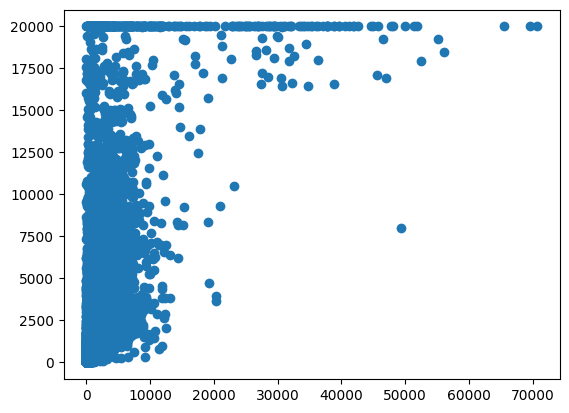

In [30]:
plt.scatter(test_preds,test_true)

In [31]:
# Prepare data for classification
X = np.stack(df['rich_embedding'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['likes_binned'])  # Assuming 'y' column exists with class labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Define a simple neural network for classification
class TweetClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(TweetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create dataset and dataloader
class TweetDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
num_classes = len(np.unique(y))
batch_size = 64
num_epochs = 100
learning_rate = 0.001

In [33]:
# Create model, optimizer, and loss function
model = TweetClassifier(input_dim, hidden_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [34]:
# Create datasets and dataloaders
train_dataset = TweetDataset(X_train, y_train)
val_dataset = TweetDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [35]:
# Training loop
print("Training classification model...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_embeddings, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch_embeddings, batch_labels in val_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
            outputs = model(batch_embeddings)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(batch_labels.cpu().numpy())
    
    val_accuracy = accuracy_score(val_true, val_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='weighted')
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

print("Training completed!")

# Save the model
torch.save(model.state_dict(), 'tweet_classifier.pth')
print("Model saved successfully!")

# Function to get predictions for new data
def predict(new_data):
    model.eval()
    with torch.no_grad():
        embeddings = torch.tensor(new_data, dtype=torch.float32).to(device)
        outputs = model(embeddings)
        _, preds = torch.max(outputs, 1)
    return label_encoder.inverse_transform(preds.cpu().numpy())

# Example usage:
# new_predictions = predict(new_embeddings)

Training classification model...


Epoch 1/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100, Loss: 0.9403, Val Accuracy: 0.7106
Precision: 0.6193, Recall: 0.7106, F1-score: 0.6617


Epoch 2/100: 100%|██████████| 3750/3750 [00:07<00:00, 475.83it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/100, Loss: 0.7626, Val Accuracy: 0.7149
Precision: 0.6159, Recall: 0.7149, F1-score: 0.6555


Epoch 3/100: 100%|██████████| 3750/3750 [00:07<00:00, 472.63it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/100, Loss: 0.7626, Val Accuracy: 0.7050
Precision: 0.6068, Recall: 0.7050, F1-score: 0.6413


Epoch 4/100: 100%|██████████| 3750/3750 [00:07<00:00, 473.55it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/100, Loss: 0.7895, Val Accuracy: 0.7082
Precision: 0.6095, Recall: 0.7082, F1-score: 0.6450


Epoch 5/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.73it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/100, Loss: 0.8014, Val Accuracy: 0.7297
Precision: 0.6296, Recall: 0.7297, F1-score: 0.6720


Epoch 6/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.10it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/100, Loss: 0.8797, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 7/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.48it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/100, Loss: 0.8842, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 8/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.68it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/100, Loss: 0.8830, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 9/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.05it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/100, Loss: 0.8823, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 10/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/100, Loss: 0.8813, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 11/100: 100%|██████████| 3750/3750 [00:07<00:00, 490.36it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/100, Loss: 0.8802, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 12/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.49it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/100, Loss: 0.8796, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 13/100: 100%|██████████| 3750/3750 [00:07<00:00, 488.75it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/100, Loss: 0.8792, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 14/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.22it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/100, Loss: 0.8786, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 15/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.83it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/100, Loss: 0.8791, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 16/100: 100%|██████████| 3750/3750 [00:07<00:00, 487.60it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/100, Loss: 0.8793, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 17/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.82it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/100, Loss: 0.8785, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 18/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.18it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/100, Loss: 0.8784, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 19/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.58it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/100, Loss: 0.8785, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 20/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.58it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/100, Loss: 0.8783, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 21/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.36it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/100, Loss: 0.8782, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 22/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.59it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/100, Loss: 0.8768, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 23/100: 100%|██████████| 3750/3750 [00:07<00:00, 476.35it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/100, Loss: 0.8768, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 24/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.71it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/100, Loss: 0.8772, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 25/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.09it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/100, Loss: 0.8772, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 26/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/100, Loss: 0.8756, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 27/100: 100%|██████████| 3750/3750 [00:07<00:00, 476.80it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/100, Loss: 0.8756, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 28/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.10it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/100, Loss: 0.8755, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 29/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.70it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/100, Loss: 0.8766, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 30/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.68it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/100, Loss: 0.8770, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 31/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.38it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/100, Loss: 0.8769, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 32/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.95it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/100, Loss: 0.8762, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 33/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.29it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/100, Loss: 0.8757, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 34/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.22it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/100, Loss: 0.8767, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 35/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.47it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/100, Loss: 0.8758, Val Accuracy: 0.7439
Precision: 0.6589, Recall: 0.7439, F1-score: 0.6980


Epoch 36/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.72it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/100, Loss: 0.8743, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 37/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.61it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/100, Loss: 0.8757, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 38/100: 100%|██████████| 3750/3750 [00:07<00:00, 473.23it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/100, Loss: 0.8761, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 39/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.29it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/100, Loss: 0.8749, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 40/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.61it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/100, Loss: 0.8750, Val Accuracy: 0.7454
Precision: 0.6760, Recall: 0.7454, F1-score: 0.7037


Epoch 41/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.41it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/100, Loss: 0.8752, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 42/100: 100%|██████████| 3750/3750 [00:07<00:00, 475.18it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/100, Loss: 0.8750, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 43/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.10it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 43/100, Loss: 0.8746, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 44/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.79it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/100, Loss: 0.8747, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 45/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.55it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 45/100, Loss: 0.8752, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 46/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.49it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/100, Loss: 0.8747, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 47/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/100, Loss: 0.8741, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 48/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.75it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/100, Loss: 0.8756, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 49/100: 100%|██████████| 3750/3750 [00:08<00:00, 447.01it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/100, Loss: 0.8758, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 50/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.71it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/100, Loss: 0.8750, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 51/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.46it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/100, Loss: 0.8748, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 52/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.67it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/100, Loss: 0.8746, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 53/100: 100%|██████████| 3750/3750 [00:08<00:00, 467.95it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/100, Loss: 0.8746, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 54/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.74it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/100, Loss: 0.8750, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 55/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/100, Loss: 0.8736, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 56/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.73it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/100, Loss: 0.8733, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 57/100: 100%|██████████| 3750/3750 [00:08<00:00, 468.31it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 57/100, Loss: 0.8757, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 58/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 58/100, Loss: 0.8743, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 59/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.00it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/100, Loss: 0.8745, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 60/100: 100%|██████████| 3750/3750 [00:07<00:00, 469.17it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/100, Loss: 0.8743, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 61/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.14it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 61/100, Loss: 0.8736, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 62/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.26it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/100, Loss: 0.8742, Val Accuracy: 0.7362
Precision: 0.6402, Recall: 0.7362, F1-score: 0.6842


Epoch 63/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.87it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/100, Loss: 0.8748, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 64/100: 100%|██████████| 3750/3750 [00:07<00:00, 472.55it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/100, Loss: 0.8735, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 65/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.39it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 65/100, Loss: 0.8742, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 66/100: 100%|██████████| 3750/3750 [00:07<00:00, 489.40it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 66/100, Loss: 0.8740, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 67/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 67/100, Loss: 0.8747, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 68/100: 100%|██████████| 3750/3750 [00:07<00:00, 482.77it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 68/100, Loss: 0.8732, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 69/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.98it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 69/100, Loss: 0.8731, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 70/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.77it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 70/100, Loss: 0.8743, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 71/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.14it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 71/100, Loss: 0.8736, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 72/100: 100%|██████████| 3750/3750 [00:07<00:00, 476.84it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 72/100, Loss: 0.8731, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 73/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.68it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 73/100, Loss: 0.8730, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 74/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.11it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 74/100, Loss: 0.8738, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 75/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.63it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 75/100, Loss: 0.8746, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 76/100: 100%|██████████| 3750/3750 [00:07<00:00, 477.87it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 76/100, Loss: 0.8734, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 77/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.79it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 77/100, Loss: 0.8732, Val Accuracy: 0.7445
Precision: 0.6788, Recall: 0.7445, F1-score: 0.7036


Epoch 78/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.78it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 78/100, Loss: 0.8746, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 79/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.84it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 79/100, Loss: 0.8741, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 80/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.94it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 80/100, Loss: 0.8741, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 81/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.00it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 81/100, Loss: 0.8738, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 82/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.67it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 82/100, Loss: 0.8731, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 83/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.24it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 83/100, Loss: 0.8732, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 84/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.99it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 84/100, Loss: 0.8738, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 85/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.86it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 85/100, Loss: 0.8740, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 86/100: 100%|██████████| 3750/3750 [00:07<00:00, 483.62it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 86/100, Loss: 0.8733, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 87/100: 100%|██████████| 3750/3750 [00:07<00:00, 478.36it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 87/100, Loss: 0.8735, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 88/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.60it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 88/100, Loss: 0.8735, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 89/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.97it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 89/100, Loss: 0.8735, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 90/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.02it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 90/100, Loss: 0.8730, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 91/100: 100%|██████████| 3750/3750 [00:07<00:00, 481.53it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 91/100, Loss: 0.8734, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 92/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.81it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 92/100, Loss: 0.8740, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 93/100: 100%|██████████| 3750/3750 [00:07<00:00, 484.53it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 93/100, Loss: 0.8737, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 94/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.45it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 94/100, Loss: 0.8735, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 95/100: 100%|██████████| 3750/3750 [00:07<00:00, 475.58it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 95/100, Loss: 0.8735, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 96/100: 100%|██████████| 3750/3750 [00:07<00:00, 480.26it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 96/100, Loss: 0.8730, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 97/100: 100%|██████████| 3750/3750 [00:07<00:00, 479.88it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 97/100, Loss: 0.8739, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 98/100: 100%|██████████| 3750/3750 [00:07<00:00, 486.18it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 98/100, Loss: 0.8731, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 99/100: 100%|██████████| 3750/3750 [00:07<00:00, 474.78it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 99/100, Loss: 0.8731, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875


Epoch 100/100: 100%|██████████| 3750/3750 [00:07<00:00, 485.17it/s]


Epoch 100/100, Loss: 0.8719, Val Accuracy: 0.5476
Precision: 0.2999, Recall: 0.5476, F1-score: 0.3875
Training completed!
Model saved successfully!


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
